# Projet Leyenda - Livrable 1 - Classification binaire

## Sommaire

* [1. Introduction](#chapiter1)
    * [1.1. Rappel du besoin](#section_1_1)
    * [1.2. Expression du besoin](#section_1_2)
    * [1.3. Contraintes](#section_1_3)
* [2. Réalisation du modèle de classification](#chapter2)
    * [2.1. Import des librairies Python](#section_2_1) 
* [3. Analyse des résultats](#chapiter3)
* [4. Amélioration du modèle](#chapiter4)
* [5. Conclusion](#chapitre5)

## 1. Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Rappel du besoin <a class="anchor" id="section_1_1"></a>

<div style="text-align: justify">Dans le cadre de ce projet l'entreprise TouNum spécialisée dans la numérisation de documents souhaite étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, leur clientèle possédant une grande quantité de données à numériser au format papier. Dans le but de rester compétitif dans ce secteur d’activité l’entreprise décide d’innover et proposer un service de catégorisation qui serait plus que valorisable. Afin de mener à bien cette tâche, des spécialistes en Data Science de CESI ont été contactés.
<p>

L’objectif de cette première partie est d’automatiser la sélection des photos pour l’annotation. Pour ce faire, nous nous basons sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos dans le dataset de départ.<div>

### 1.2 Expression du besoin <a class="anchor" id="section_1_2"></a>

<div style="text-align: justify">Afin d’apporter une réponse adaptée à la problématique énoncée dans l’introduction de ce notebook. Il nous apparaît intéressant d’analyser le besoin de l’utilisateur final. Cette démarche a pour but de 
donner un point de vue global des attendus aux quelles la solution doit répondre. Ce qui nous 
donnera une ligne directrice à suivre tout au long de ce notebook. Afin, de donner un aperçu plus clair sur la marche à suivre pour répondre au besoin exprimé nous pouvons nous aider du diagramme bête à corne ci dessous.</div>

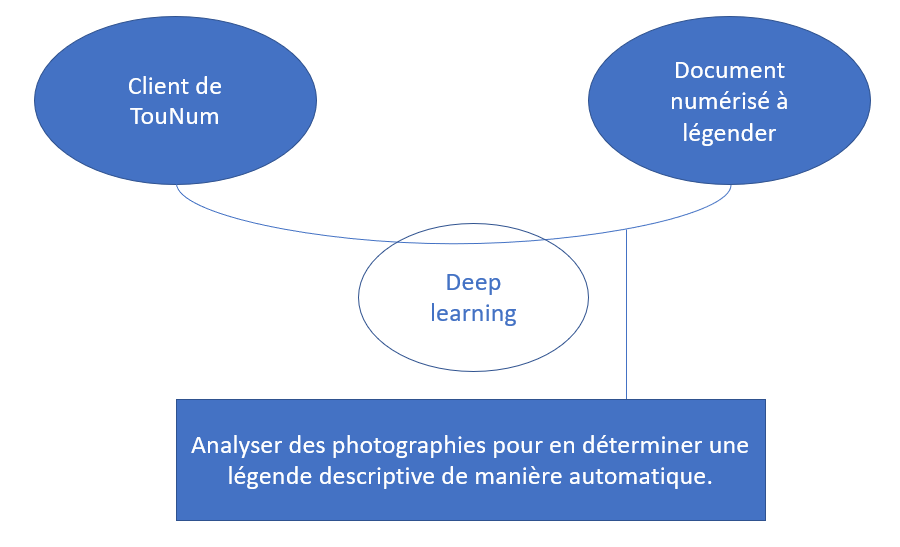
<center><em>Diagrame Bete à corne</em></center>

### 1.3 Contraintes <a class="anchor" id="section_1_3"></a>

<div style="text-align: justify">Cette première partie comporte plusieurs contraintes liées à la vision par ordinateur. En effet, nous devons être en capacité de déterminer si les images sont des photos sans tenir compte de l’orientation, de la luminosité, ou la  variation d’échelle de celles-ci. De plus, nous devrons extraire les features qui nous permettrons de distinguer les différences entre les types d’images qui composent le dataset.</div>  

## 2. Réalisation du modèle de classification <a class="anchor" id="chapter2"></a>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import pathlib

data_dir = pathlib.Path("Class")

In [6]:
image_h = 180
image_w = 180
batch_s = 32

In [7]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="training",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset ="validation",
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  label_mode = "binary"
)

Found 32079 files belonging to 2 classes.
Using 25664 files for training.
Found 32079 files belonging to 2 classes.
Using 6415 files for validation.


In [8]:
class_names = train_set.class_names
print(class_names)

['Autre', 'Photo']


In [9]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 1)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

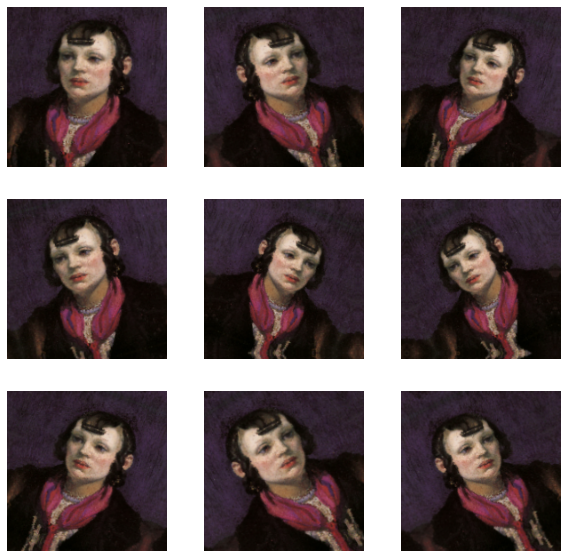

In [11]:
#Fonction s'occupant de la data augmentation, aujoutant au dataset d'entrainement des images légèrements modifiées par leur orientation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(image_h, 
                                                              image_w,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)       

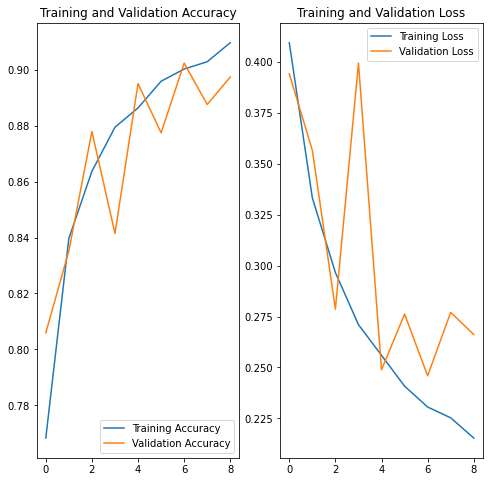

In [243]:
#def my_init(shape, dtype=None):     return K.random_normal(shape, dtype=tf.int32)

# Le modèle
complete_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])
# Compilation du modèle
complete_model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()

# Enrainement du modèle
epochs = 9
with tf.device('/device:GPU:0'):
  history = complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
  )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CALCUL DES INDICATEURS DE QUALITÉ : Matrice de confusion, Courbe ROC et L'air sous la courbe ROC

On affiche la matrice de confusion calculée sur nos données : On affiche la précision, le recall et le F1 Score 2 fois, une fois calculée avec la librairie et une fois calculée manuellement pour vérifier

In [27]:
# from sklearn.metrics import classification_report

# predictions = complete_model.predict(test_set)
# predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
# true_categories = tf.concat([y for x, y in test_set], axis=0)


# print(classification_report(true_categories, predicted_categories, target_names = class_names ))

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

predictions = complete_model.predict(test_set)
predicted_categories = [1 * (x[0]>=0.5) for x in predictions]
true_categories = tf.concat([y for x, y in test_set], axis=0)

conf_matrix = confusion_matrix(true_categories, predicted_categories)
precision_score = precision_score(true_categories, predicted_categories)
recall_score = recall_score(true_categories, predicted_categories)
f1_score = f1_score(true_categories, predicted_categories)


TP = conf_matrix[1,1]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
calc_precision_accuracy = TP/(TP+FP)
calc_recall_accuracy = TP/(TP+FN)


print(conf_matrix)
print("Precision score: "+str(precision_score)+" Recall Score: "+str(recall_score)+" F1 Score: "+str(f1_score))
print("Calculated precision score: "+str(calc_precision_accuracy)+" Calculated recall score: "+ str(calc_recall_accuracy))


[[4013  318]
 [ 156 1928]]
Precision score: 0.8584149599287623 Recall Score: 0.9251439539347409 F1 Score: 0.8905311778290993
Calculated precision score: 0.8584149599287623 Calculated recall score: 0.9251439539347409


In [28]:
complete_model.evaluate(test_set)

201/201 [==============================] - 2s 9ms/step - loss: 0.1921 - accuracy: 0.9261


[0.19206951558589935, 0.9261106848716736]

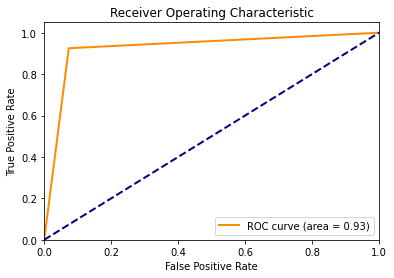

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(true_categories, predicted_categories)

roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

La diagonal en pointillé représente la ROC d un classifier aléatoire. Un classificateur idéal s en écarte au maximum en épousant le coin supérieur gauche.

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(true_categories, predicted_categories)

0.9258599012342833

On utilise comme métrique de comparaison l air sous la courbe ROC, que l on souhaite la plus proche possible de 1. On calcule donc le ROC AUC SCORE.

In [246]:
complete_model.save('saved_model/my_model')


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [2]:
from tensorflow.keras.models import load_model

complete_model = load_model('saved_model/my_model')

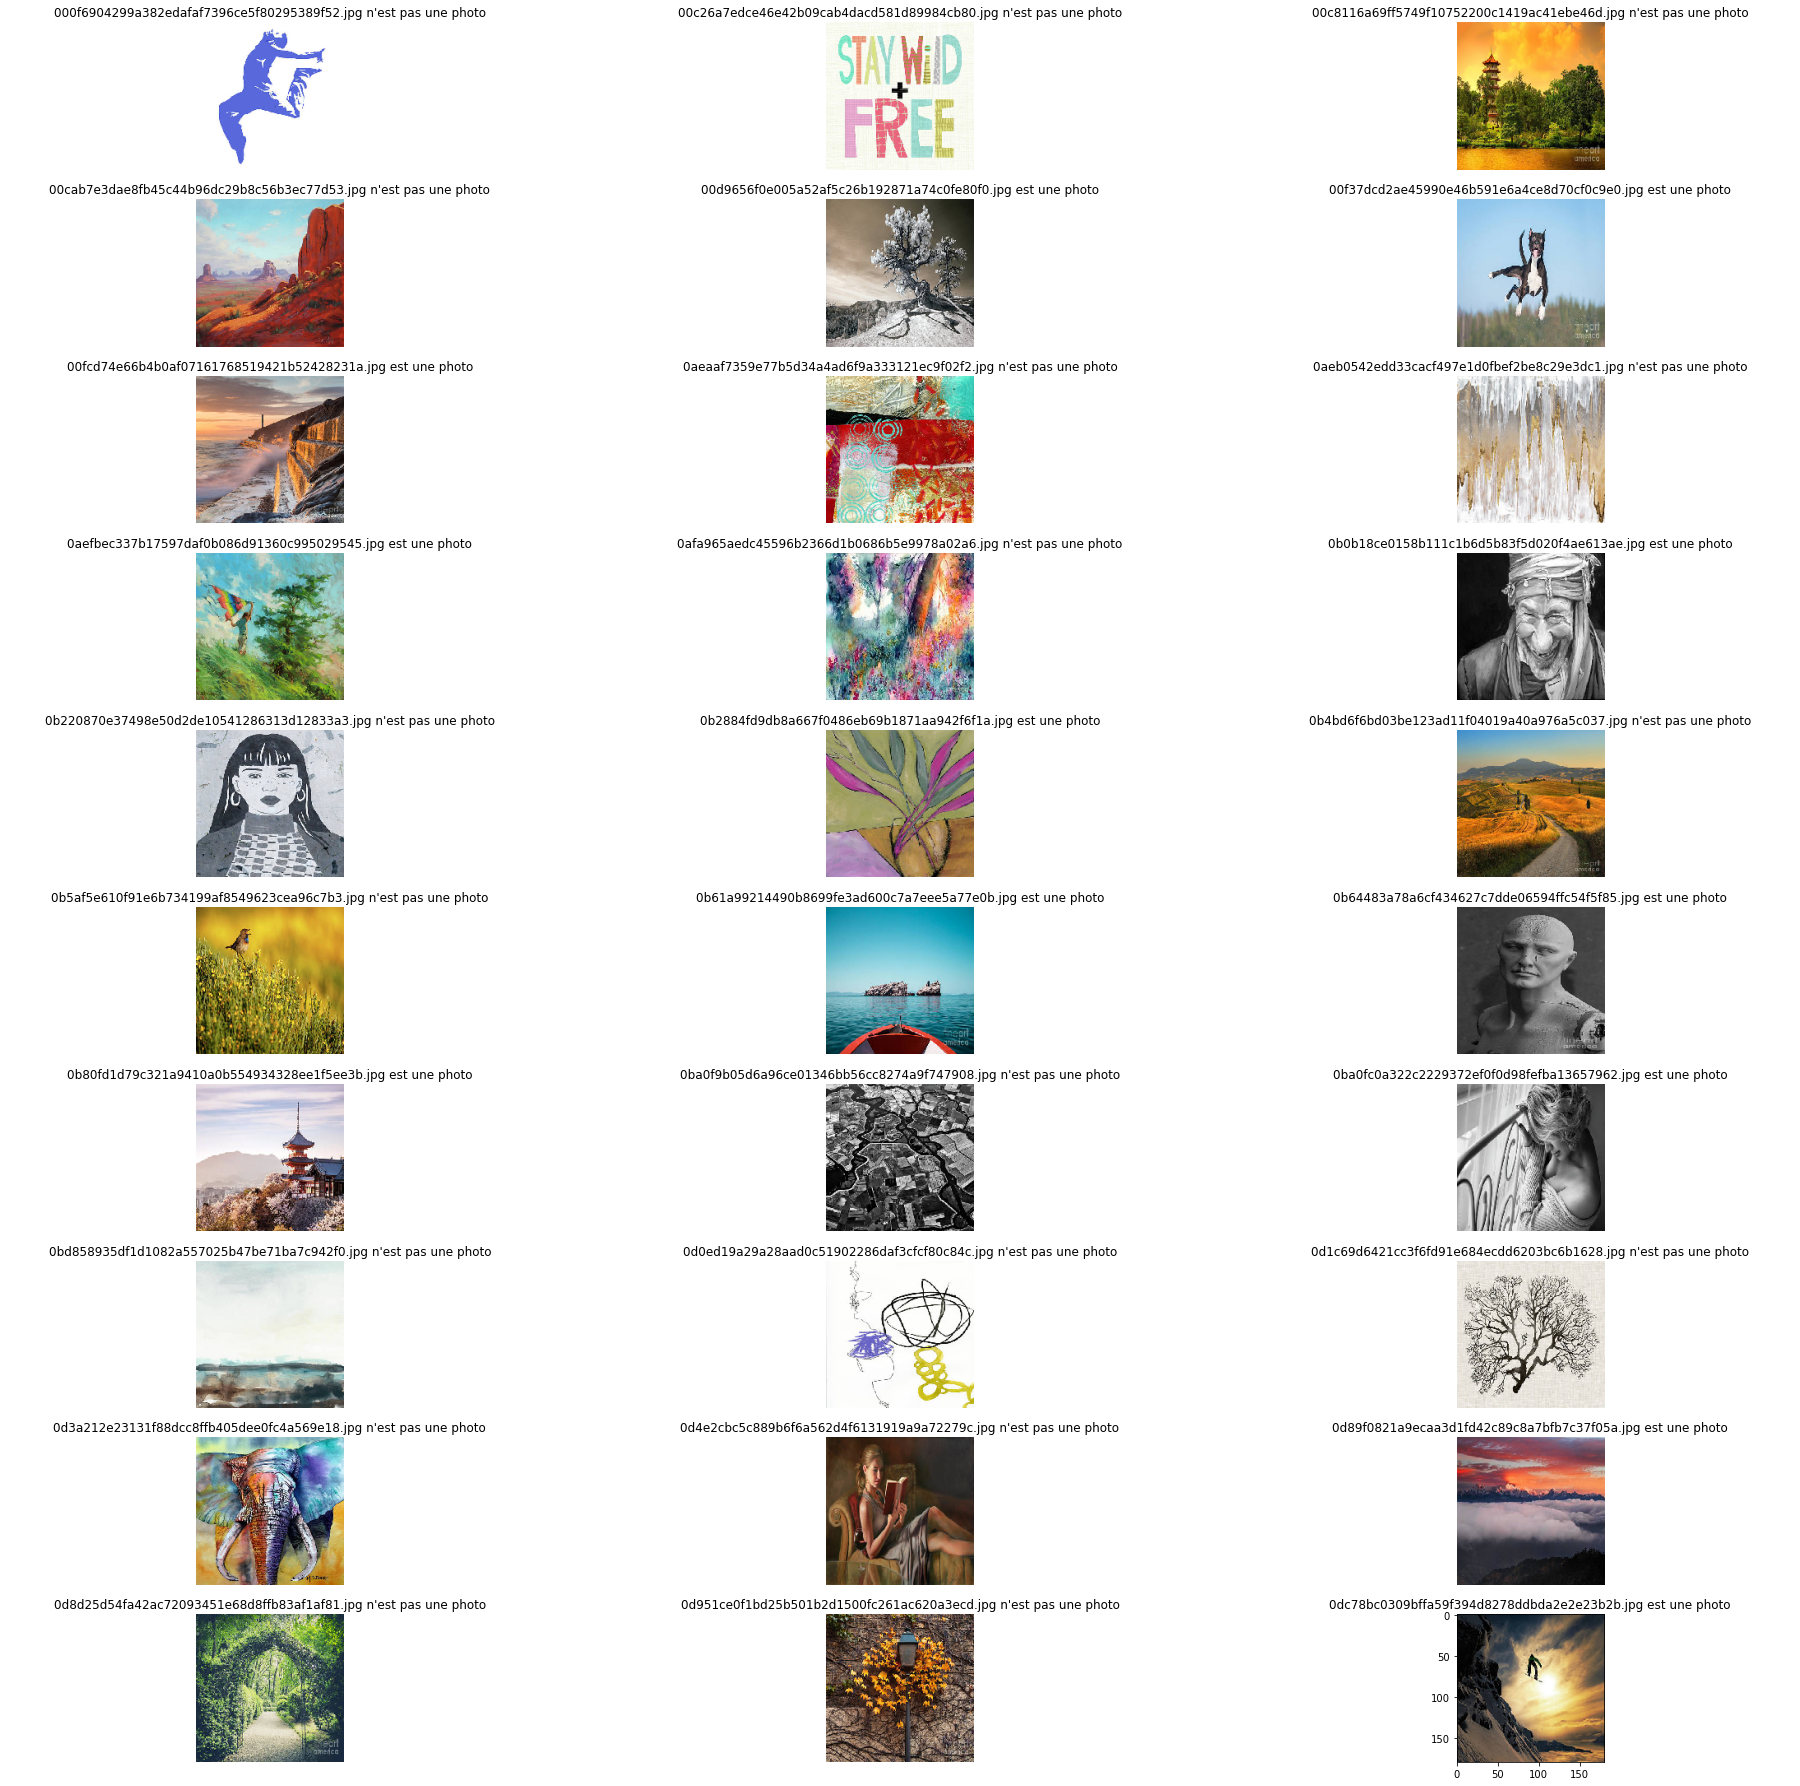

In [3]:
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

from keras.preprocessing import image

onlyfiles = [f for f in listdir('images_test') if isfile(join('images_test', f))]

fig = plt.figure(figsize=(32, 32))
ax = []

for i in range(len(onlyfiles)):

  img = image.load_img('images_test/'+onlyfiles[i], target_size=(180, 180))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  plt.axis('off')
  
  #rendre ligne colonne dynamique par rapport au nb images dans le fichier
  ax.append( fig.add_subplot(math.ceil(len(onlyfiles)/3), 3, i+1) )

  images = np.vstack([x])
  classes = complete_model.predict(images, batch_size=10)

  if classes[0]<0.5:
    ax[-1].set_title(onlyfiles[i] + " n'est pas une photo")  # set title
  else:
    ax[-1].set_title(onlyfiles[i] + " est une photo")  # set title
  plt.imshow(img)


plt.show()
